In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
import datetime as datetime
sys.path.insert(1, '/home/sypmauu/GalapagosProject/scripts/functions')
from ParticlePlotFunctions import *
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


### Velocity fields MITgcm

UVEL(time, YC, XG) & VVEL(time, YG, XC)

Check how particles moves through U or V grid close to land points 

In [2]:
Ufiles = '/home/sypmauu/GalapagosProject/data/MIT4km/RGEMS_2008_Surf.nc'
Xfiles = '/home/sypmauu/GalapagosProject/data/MIT4km/RGEMS3_Surf_grid.nc'

date = 200

dfile = Dataset(Ufiles)
Uvel = dfile.variables['UVEL'][date,:,:]
Vvel = dfile.variables['VVEL'][date,:,:]
dfile = Dataset(Xfiles)
bathy = dfile.variables['maskC'][0,:,:]
XG = dfile.variables['XG'][:]
YG = dfile.variables['YG'][:]
XC = dfile.variables['XC'][:]
YC = dfile.variables['YC'][:]

Uvel[Uvel==0]=nan
Vvel[Vvel==0]=nan

### Some trajectories

In [3]:
namefile = '../../data_output/DrifterRelease_200615.nc'
Traj = ReadTrajectories(namefile)
release_time = 293  #number of releases at specific location 
release_loc = 675   #number of release locations
total_particles = Traj['lon'].shape[0]

startlon = Traj['lon'][0:release_loc,0]
startlat = Traj['lat'][0:release_loc,0]

### Check how many particles 'beach'

Saves all end lon/lat of all particles and check where they are at that time.

Clearly most particles leave the domain. The ones that do not are not 'advected' onto land, but get stuck -> 4% of total

In [40]:
endloc1 = np.zeros((2,Traj['lon'].shape[0]))
endloc2 = np.zeros((2,Traj['lon'].shape[0]))
particlelong = []

for p in range(Traj['lon'].shape[0]):
    indexloc = np.where(isnan(Traj['lon'][p,:]))[0]
    if indexloc.any():
        endloc1[0,p]=Traj['lon'][p,indexloc[0]-1]
        endloc1[1,p]=Traj['lat'][p,indexloc[0]-1]
    else:
        endloc2[0,p]=Traj['lon'][p,-1]
        endloc2[1,p]=Traj['lat'][p,-1]
        particlelong.append(p)
print(len(particlelong)/p*100)
#map_extent = [-95,-87.5,-2,1]      
#fig, ax = plt.subplots(1,figsize=(8,8))
#ax.scatter(endloc1[0,:],endloc1[1,:],s=40,c='k')
#ax.scatter(endloc2[0,:],endloc2[1,:],s=40,c='r')
#ax.set_xlim(map_extent[0:2])
#ax.set_ylim(map_extent[2:4])
#ax.plot(Traj['lon'][particlelong,:].T,Traj['lat'][particlelong,:].T) 

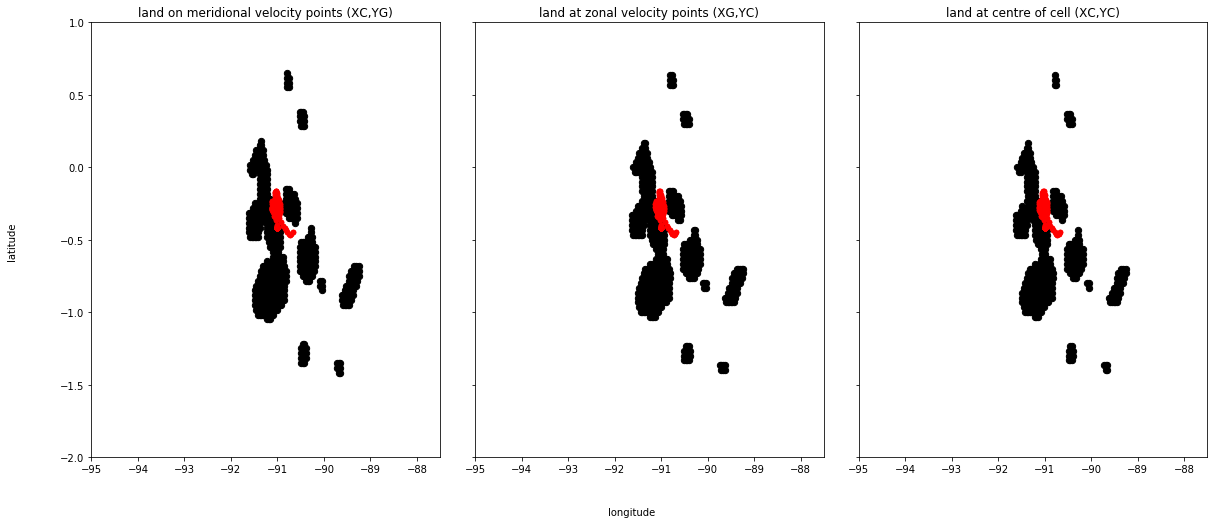

In [37]:
map_extent = [-95,-87.5,-2,1]   
figsize=(20, 8)                            
particle1 = particlelong[20]
particle2 = particlelong[20]
particle3 = particlelong[20]

fig, ax = plt.subplots(1,3,figsize=figsize,
                           sharex = True, 
                           sharey = True)
fig.subplots_adjust(hspace=.5, wspace=.1)
ax = ax.ravel()
fig.text(0.5, 0.03, 'longitude', ha='center', va='center')
fig.text(0.07, 0.5, 'latitude', ha='center', va='center', rotation='vertical')


Vlandmask = np.where(isnan(Vvel))
Vlon = XC[Vlandmask[1][:]]
Vlat = YG[Vlandmask[0][:]]   
ax[0].scatter(Vlon,Vlat,s=40,c='k')
ax[0].scatter(Traj['lon'][particle1,:],Traj['lat'][particle1,:],s=20,c='r')   
ax[0].scatter(Traj['lon'][particle2,:],Traj['lat'][particle2,:],s=20,c='r')   
ax[0].scatter(Traj['lon'][particle3,:],Traj['lat'][particle3,:],s=20,c='r')   
ax[0].set_title('land on meridional velocity points (XC,YG)')          
ax[0].set_xlim(map_extent[0:2])
ax[0].set_ylim(map_extent[2:4])

Ulandmask = np.where(isnan(Uvel))
Ulon = XG[Ulandmask[1][:]]
Ulat = YC[Ulandmask[0][:]]   
ax[1].scatter(Ulon,Ulat,s=40,c='k')
ax[1].scatter(Traj['lon'][particle1,:],Traj['lat'][particle1,:],s=20,c='r')   
ax[1].scatter(Traj['lon'][particle2,:],Traj['lat'][particle2,:],s=20,c='r')   
ax[1].scatter(Traj['lon'][particle3,:],Traj['lat'][particle3,:],s=20,c='r')
ax[1].set_title('land at zonal velocity points (XG,YC)')          
ax[1].set_xlim(map_extent[0:2])
ax[1].set_ylim(map_extent[2:4])

Clandmask = np.where(bathy==0)
Clon = XC[Clandmask[1][:]]
Clat = YC[Clandmask[0][:]]   
ax[2].scatter(Clon,Clat,s=40,c='k')
ax[2].scatter(Traj['lon'][particle1,:],Traj['lat'][particle1,:],s=20,c='r')   
ax[2].scatter(Traj['lon'][particle2,:],Traj['lat'][particle2,:],s=20,c='r')   
ax[2].scatter(Traj['lon'][particle3,:],Traj['lat'][particle3,:],s=20,c='r')
ax[2].plot(Traj['lon'][particle3,:],Traj['lat'][particle3,:],'r')
ax[2].set_title('land at centre of cell (XC,YC)')          
ax[2].set_xlim(map_extent[0:2])
ax[2].set_ylim(map_extent[2:4])

plt.savefig('land_points_cgrid.png', dpi=300)